In [42]:
import os
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import collections
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation  
from string import digits
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import metrics
# use if required
#!pip install contractions
import contractions
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import f1_score
import seaborn as sns
import datetime

In [4]:
# Use only when using colab to mount the drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
#Preprocessing
#Use these if required.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# create a lemmatizer object
lemmatizer = nltk.stem.WordNetLemmatizer()
# create an object to remove punctuation marks
puncutation_translator = str.maketrans('', '', punctuation)
digit_translator = str.maketrans('', '', digits)
# create a stop word list (*** Check if negation words need to be eliminated from the list ***)
stopwords_list = set(stopwords.words('english') + list(punctuation) + ['ATUSER','URL'])

## function for pre-preocessing individual tweet
## 1. Changing it into lowercase
## 2. Fixing contractions. For e.g. can't -> can not
## 3. Removing URLs
## 4. Removing usernames.
## 5. Removing Punctutation marks.
## 6. Removing digits.
## 7. Tokenizing sentences into words.
## 8. Lemmatization of each word assuming it's POS tag as verb.
## 9. Removing stop words.
def preProcessTweet(tweet_elm):
  tweet = tweet_elm.lower()
  tweet = contractions.fix(tweet)
  tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)
  tweet = re.sub('@[^\s]+', 'ATUSER', tweet)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  tweet = tweet.translate(puncutation_translator)
  tweet = tweet.translate(digit_translator)
  tweet = word_tokenize(tweet)
  return " ".join([lemmatizer.lemmatize(word, 'v') for word in tweet if word not in stopwords_list])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# extract vaccine dataset
dataFrame_vaccine_trend = pd.read_csv("/content/drive/My Drive/study/data_analytics/project/src/covid_data/vaccine_tweets_jan_2021.csv", encoding = "utf8") 
dataFrame_vaccine_trend.head()

,date,tweet
0,2021-01-01 00:00:00+00:00,The distribution of the COVID-19 vaccine will ...
1,2021-01-01 00:00:00+00:00,COVID-19 Vaccine Rollout Is Way Behind Schedul...
2,2021-01-01 00:00:00+00:00,The Hamilton County Health Department was forc...
3,2021-01-01 00:00:00+00:00,So we've entered 2021. 2020 has been very bad ...
4,2021-01-01 00:00:01+00:00,Covid vaccines are rolling out &amp; hope is o...


In [7]:
# extract sentiment ratings and tweets
tweets_vaccine = dataFrame_vaccine_trend.iloc[:, 1].to_numpy()

In [8]:
# Process tweets
processed_tweets_vaccine = []
for tweet in tweets_vaccine:
  processed_tweets_vaccine.append(preProcessTweet(tweet))

In [9]:
## VADER Analysis
!pip install twython
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [10]:
# Vader Analyzer oObject
vaderSentimentAnalyzer = SentimentIntensityAnalyzer()

tweet_sentiment_vader = []
neg_sentiment = 0
pos_sentiment = 0
neu_sentiment = 0

for tweet in tweets_vaccine:#processed_tweets_vaccine:
  score = vaderSentimentAnalyzer.polarity_scores(tweet)
  sentiment = score['compound']
  
  if (sentiment < 0):
    neg_sentiment += 1
    tweet_sentiment_vader.append("negative")
  elif (sentiment > 0):
    pos_sentiment += 1
    tweet_sentiment_vader.append("positive")
  elif (sentiment == 0):
    neu_sentiment += 1
    tweet_sentiment_vader.append("neutral")

In [11]:
# Encode sentiments for model training
one_hot_encoding = {'negative': 0, 'positive': 2, 'neutral': 1}

tweet_sentiment_vader_ohe = []
for sentiment in tweet_sentiment_vader:
  tweet_sentiment_vader_ohe.append(one_hot_encoding[sentiment])

In [35]:
# Get precision and recall score and plot confusion matrix
rev_one_hot_encoding = {0: 'negative', 2: 'positive', 1: 'neutral'}
tweet_sentiment_pred_vader_Y_test = []
tweet_sentiment_pred_vader_Y_pred = []

def calulatePrecisionRecall(Y_test, Y_pred, model):
  for sentiment in Y_test:
    tweet_sentiment_pred_vader_Y_test.append(rev_one_hot_encoding[sentiment])


  for sentiment in Y_pred:
    tweet_sentiment_pred_vader_Y_pred.append(rev_one_hot_encoding[sentiment])


  print(metrics.classification_report(tweet_sentiment_pred_vader_Y_test, tweet_sentiment_pred_vader_Y_pred, digits=8))

  cnf_matrix = confusion_matrix(tweet_sentiment_pred_vader_Y_test, tweet_sentiment_pred_vader_Y_pred)

  fig = plt.figure(figsize = (7, 7))
  fig.suptitle("Confusion Matrix for " + model + " Model", fontsize=14)
  ax = fig.add_subplot(111)
  sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap=plt.cm.BuGn)

In [12]:
# Get training and testing split
X_train, X_test, Y_train, Y_test = train_test_split(processed_tweets_vaccine, tweet_sentiment_vader_ohe, test_size = 0.2, random_state = 30)

In [13]:
# Tokenize tweets and pad them to make them of same length
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets_vaccine)

Xvectorized_train = tokenizer.texts_to_sequences(X_train)
Xvectorized_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
Xvectorized_train = tf.keras.preprocessing.sequence.pad_sequences(Xvectorized_train, padding='post', maxlen=maxlen)
Xvectorized_test = tf.keras.preprocessing.sequence.pad_sequences(Xvectorized_test, padding='post', maxlen=maxlen)

In [14]:
# Build an ANN model
def buildModel3Classes(vocab_size, maxlen):
  tf.debugging.set_log_device_placement(True)
  tf.config.run_functions_eagerly(False)

  with tf.device('/gpu:0'):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
    model.add(embedding_layer)

    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

    print(model.summary())

    return model

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          102199900 
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               2000200   
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 603       
Total params: 104,200,703
Trainable params: 104,200,703
Non-trainable params

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


528882/528882 [==============================] - 8s 16us/sample - loss: 0.7776 - acc: 0.6372 - val_loss: 0.4681 - val_acc: 0.8337
Epoch 2/10
528882/528882 [==============================] - 8s 15us/sample - loss: 0.4111 - acc: 0.8572 - val_loss: 0.3978 - val_acc: 0.8638
Epoch 3/10
528882/528882 [==============================] - 8s 16us/sample - loss: 0.3748 - acc: 0.8714 - val_loss: 0.3846 - val_acc: 0.8680
Epoch 4/10
528882/528882 [==============================] - 8s 15us/sample - loss: 0.3568 - acc: 0.8775 - val_loss: 0.3894 - val_acc: 0.8652
Epoch 5/10
528882/528882 [==============================] - 8s 16us/sample - loss: 0.3421 - acc: 0.8821 - val_loss: 0.3776 - val_acc: 0.8708
Epoch 6/10
528882/528882 [==============================] - 8s 15us/sample - loss: 0.3283 - acc: 0.8867 - val_loss: 0.3796 - val_acc: 0.8704
Epoch 7/10
528882/528882 [==============================] - 8s 16us/sample - loss: 0.3155 - acc: 0.8911 - val_loss: 0.3828 - val_acc: 0.8693
Epoch 8/10
528882/528882

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


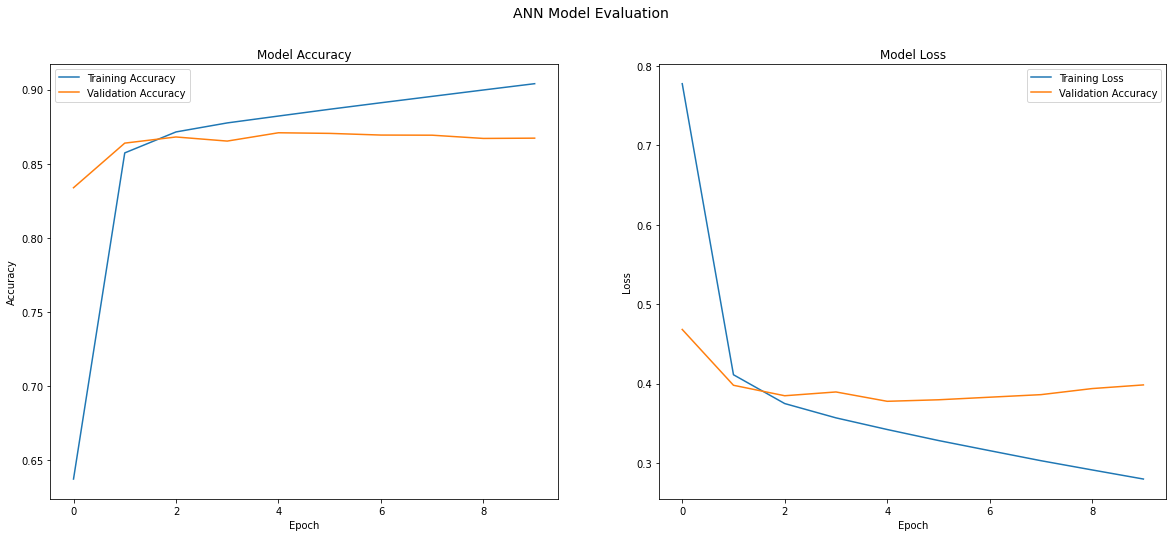

In [25]:
# Train ANN model with GPU
Y_pred = []
with tf.compat.v1.Session() as sess:
  sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
  model = buildModel3Classes(vocab_size, maxlen)

  #history = model.fit(Xvectorized_train, Y_train, batch_size=4096, epochs=10, verbose=1, validation_split=0.2)
  start_time = datetime.datetime.now()
  history = model.fit(Xvectorized_train, Y_train, batch_size=4096, epochs=10, verbose=1, validation_split=0.2)
  end_time = datetime.datetime.now()

  time_diff = (end_time - start_time)
  execution_time = time_diff.total_seconds()
  print("ANN Model Training Time: " + str(execution_time) + " seconds")

  Y_pred = model.predict_classes(Xvectorized_test)
  
  fig = plt.figure(figsize=(20, 8))
  fig.suptitle("ANN Model Evaluation", fontsize=14)

  # Plot Accuracy and Loss
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title("Model Accuracy")
  ax.plot(history.history['acc'], label="Training Accuracy")
  ax.plot(history.history['val_acc'], label="Validation Accuracy")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  ax.set_title("Model Loss")
  ax.plot(history.history['loss'], label="Training Loss")
  ax.plot(history.history['val_loss'], label="Validation Accuracy")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.legend()

  plt.show()

              precision    recall  f1-score   support

    negative  0.83787944 0.81447639 0.82601218     50123
     neutral  0.88758348 0.92100355 0.90398474     50939
    positive  0.87204848 0.86501386 0.86851693     64214

    accuracy                      0.86694378    165276
   macro avg  0.86583713 0.86683127 0.86617128    165276
weighted avg  0.86647406 0.86694378 0.86655796    165276



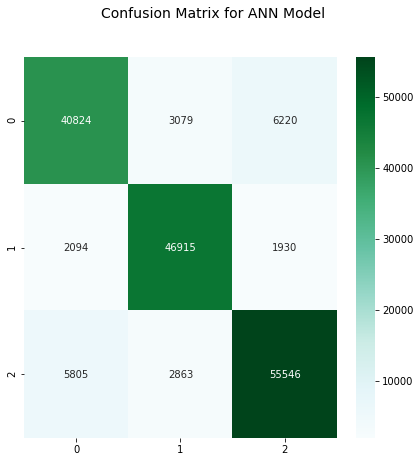

In [36]:
# Compute precision and recall score
calulatePrecisionRecall(Y_test, Y_pred, "ANN")

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         102199900 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 603       
Total params: 102,441,303
Trainable params: 102,441,303
Non-trainable params

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


528882/528882 [==============================] - 75s 142us/sample - loss: 0.6386 - accuracy: 0.7309 - val_loss: 0.4153 - val_accuracy: 0.8569
Epoch 2/10
528882/528882 [==============================] - 73s 138us/sample - loss: 0.4161 - accuracy: 0.8568 - val_loss: 0.3979 - val_accuracy: 0.8628
Epoch 3/10
528882/528882 [==============================] - 73s 138us/sample - loss: 0.4015 - accuracy: 0.8612 - val_loss: 0.3936 - val_accuracy: 0.8645
Epoch 4/10
528882/528882 [==============================] - 73s 138us/sample - loss: 0.3925 - accuracy: 0.8642 - val_loss: 0.3881 - val_accuracy: 0.8661
Epoch 5/10
528882/528882 [==============================] - 73s 138us/sample - loss: 0.3856 - accuracy: 0.8669 - val_loss: 0.3811 - val_accuracy: 0.8686
Epoch 6/10
528882/528882 [==============================] - 73s 138us/sample - loss: 0.3777 - accuracy: 0.8693 - val_loss: 0.3740 - val_accuracy: 0.8711
Epoch 7/10
528882/528882 [==============================] - 73s 137us/sample - loss: 0.3705 -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


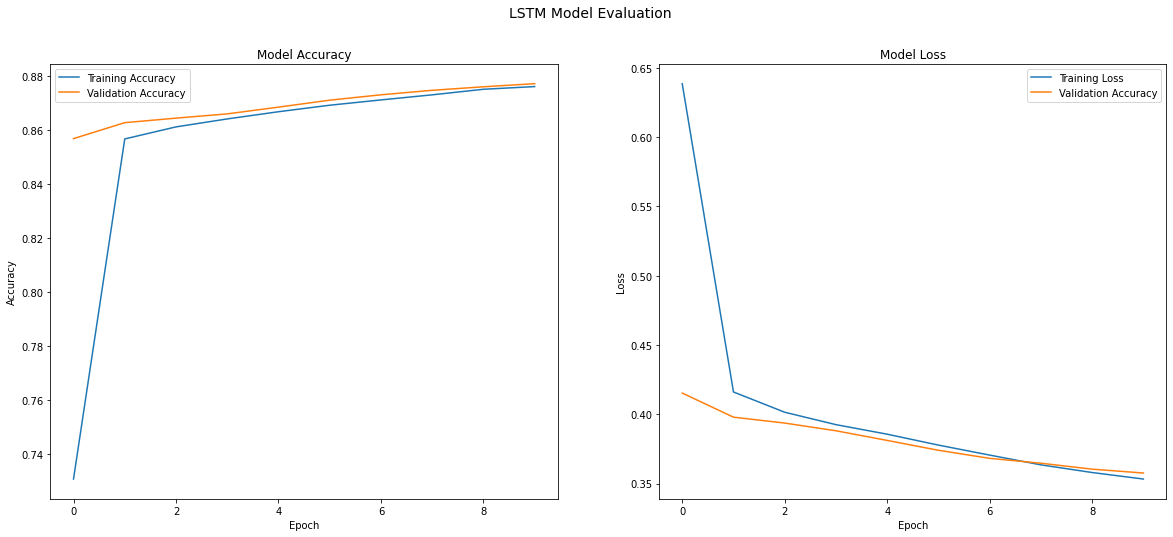

In [39]:
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D



# Create LSTM Model
def buildModel(vocabl_size, maxlen):
  with tf.device('/gpu:0'):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, mask_zero=True)

    model.add(embedding_layer)
    model.add(tf.keras.layers.SpatialDropout1D(0.4))
    model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.3,return_sequences=False))
    
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    print(model.summary())
    return model

# Train LSTM Model
with tf.compat.v1.Session() as sess:
  sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
  model = buildModel(vocab_size, maxlen)
  
  start_time = datetime.datetime.now()
  history = model.fit(Xvectorized_train, Y_train, batch_size=4096, epochs=10, verbose=1, validation_split=0.2)
  end_time = datetime.datetime.now()

  time_diff = (end_time - start_time)
  execution_time = time_diff.total_seconds()
  print("LSTM Model Training Time: " + str(execution_time) + " seconds")

  Y_pred = model.predict_classes(Xvectorized_test)

  fig = plt.figure(figsize=(20, 8))
  fig.suptitle("LSTM Model Evaluation", fontsize=14)

  ax = fig.add_subplot(1, 2, 1)
  ax.set_title("Model Accuracy")
  ax.plot(history.history['accuracy'], label="Training Accuracy")
  ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  ax.set_title("Model Loss")
  ax.plot(history.history['loss'], label="Training Loss")
  ax.plot(history.history['val_loss'], label="Validation Accuracy")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.legend()

  plt.show()  

              precision    recall  f1-score   support

    negative  0.85510514 0.80970812 0.83178767    100246
     neutral  0.88395644 0.93133945 0.90702954    101878
    positive  0.87402661 0.87308064 0.87355337    128428

    accuracy                      0.87181744    330552
   macro avg  0.87102940 0.87137607 0.87079019    330552
weighted avg  0.87134875 0.87181744 0.87120470    330552



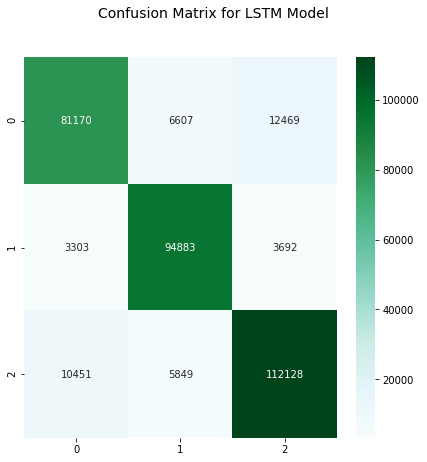

In [40]:
# Compute precision and recall score
calulatePrecisionRecall(Y_test, Y_pred, "LSTM")

In [43]:
# Compute TF-IDF
tfidfvectorizer = TfidfVectorizer(analyzer= 'word', stop_words='english')

tfidf_vectorizer = tfidfvectorizer.fit(processed_tweets_vaccine)
X = tfidf_vectorizer.transform(processed_tweets_vaccine)
Y = tweet_sentiment_vader_ohe

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)

In [44]:
# Training Sentimental Analysis using Naive Bayes Model
naive_bayes_classifier = MultinomialNB()
start_time = datetime.datetime.now()
naive_bayes_classifier.fit(X_train, Y_train)
end_time = datetime.datetime.now()

time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()
print("Execution Time for Naive Bayes Model : " +str(execution_time))
Y_pred = naive_bayes_classifier.predict(X_test)

Execution Time for Naive Bayes Model : 0.26331


              precision    recall  f1-score   support

    negative  0.81638993 0.74452846 0.77880502    200492
     neutral  0.87936916 0.77306681 0.82279873    203756
    positive  0.74710749 0.87008285 0.80391949    256856

    accuracy                      0.80210527    661104
   macro avg  0.81428886 0.79589270 0.80184108    661104
weighted avg  0.80888247 0.80210527 0.80212175    661104



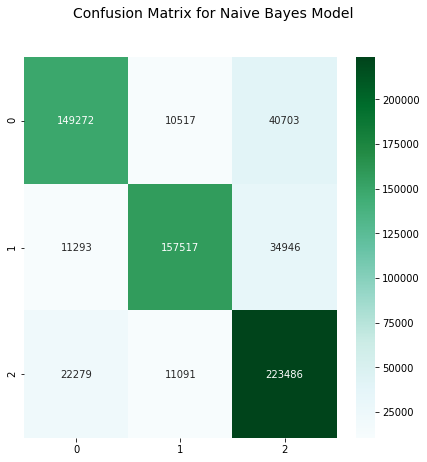

In [46]:
# Compute precision and recall score
calulatePrecisionRecall(Y_test, Y_pred, "Naive Bayes")

In [49]:
# Train logistoc regression model
logistic_regression_classifier = LogisticRegression(solver='saga')
start_time = datetime.datetime.now()
logistic_regression_classifier.fit(X_train, Y_train)
end_time = datetime.datetime.now()

time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()
print("Execution Time for Logistic Regression Model : " + str(execution_time))
Y_pred = logistic_regression_classifier.predict(X_test)

Execution Time for Logistic Regression Model : 15.712766


              precision    recall  f1-score   support

    negative  0.83662810 0.77440496 0.80431490    300738
     neutral  0.88228835 0.82809831 0.85433488    305634
    positive  0.78776942 0.87188412 0.82769522    385284

    accuracy                      0.82882673    991656
   macro avg  0.83556196 0.82479580 0.82878167    991656
weighted avg  0.83171799 0.82882673 0.82881520    991656



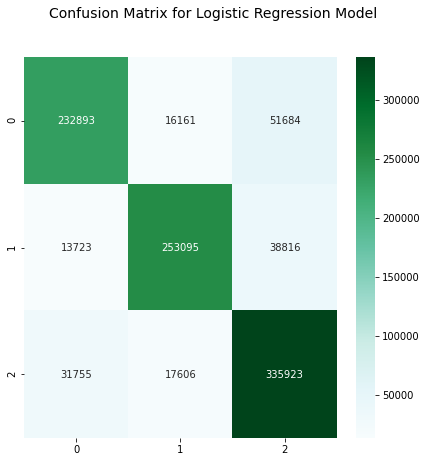

In [50]:
# Compute precision and recall score
calulatePrecisionRecall(Y_test, Y_pred, "Logistic Regression")